In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import cvxportfolio as cp
%run ../../Personal-Investing/bin/data

In [4]:
bbg = BBG()

Download the problem data from Bloomberg. We select four liquid stocks, and the risk-free rate.

In [5]:
tickers = ['AMZN US Equity', 'GOOGL US Equity', 'TSLA US Equity', 'NKE US Equity']
start_date='20120101'
end_date='20161231'
returns = bbg.getBbgHistData(tickers, field='PX_LAST', start=start_date, end=end_date).pct_change()

In [6]:
returns['USDOLLAR'] = bbg.getBbgHistData(['USGG3M Index'], field='PX_LAST', start=start_date,end=end_date)/250/100
#returns = returns.drop('USGG3M Index',1)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN US Equity,GOOGL US Equity,TSLA US Equity,NKE US Equity,USDOLLAR
2016-12-23,-0.007503,-0.002322,0.023459,-0.004411,0.000020
2016-12-27,0.014213,0.002637,0.029015,-0.011944,0.000021
2016-12-28,0.000946,-0.006618,0.000957,-0.005265,0.000020
2016-12-29,-0.009040,-0.002101,-0.023027,0.000785,0.000018
2016-12-30,-0.019970,-0.012991,-0.004612,-0.004506,0.000020


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [7]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.head()

,AMZN US Equity,GOOGL US Equity,TSLA US Equity,NKE US Equity,USDOLLAR
2013-01-03,0.001646,0.000438,0.001491,0.000439,0.000003
2013-01-04,0.001698,0.000423,0.001477,0.000422,0.000003
2013-01-07,0.001706,0.000557,0.001520,0.000463,0.000003
2013-01-08,0.001737,0.000595,0.001544,0.000476,0.000003
2013-01-09,0.001795,0.000756,0.001416,0.000419,0.000003


Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [10]:
tcost_model=cp.TcostModel(half_spread=10E-4, nonlin_coeff=1.)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [11]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [12]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-09',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                              1003
Initial timestamp               2013-01-09 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         23.438
Excess return (%)                            23.332
Excess risk (%)                              21.399
Sharpe ratio                                  1.091
Max. drawdown                                20.131
Turnover (%)                                 95.216
Average policy time (sec)                     0.049
Average simulator time (sec)                  0.003


The total value of the portfolio in time.

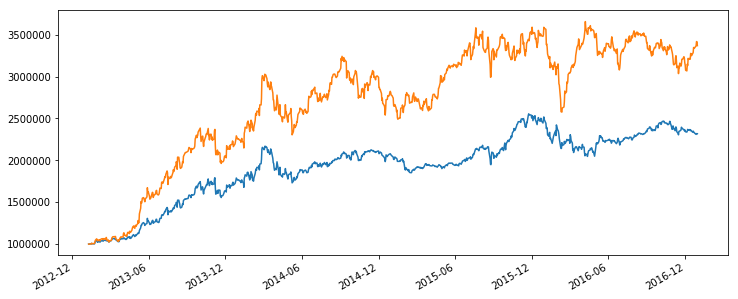

In [13]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

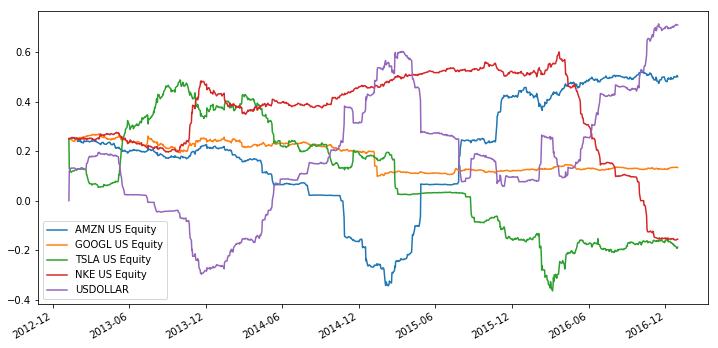

In [14]:
results[0].w.plot(figsize=(12,6))